<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:

# Install required packages
!pip install -q wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow pytorch_lightning pytorch_forecasting

# Set up Kaggle API
!pip install -q kaggle  dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.1 MB/s eta 0:00:00


In [8]:

# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


In [9]:

# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:

!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip


replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [11]:
# Walmart Store Sales Forecasting - LightGBM Model Experiment
# ================================================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# MLflow for experiment tracking
import mlflow
import mlflow.lightgbm
import mlflow.sklearn
from mlflow.tracking import MlflowClient



In [42]:


# # Set up MLflow
import dagshub
dagshub.init(repo_owner='ekvirika', repo_name='WalmartRecruiting', mlflow=True)
print("ბიბლიოთეკები წარმატებით ჩაიტვირთა!")


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=0e2fdc90-85ce-4499-ab85-5e08e01f96f9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=4102b5d452239f2bc8c0069f967d24a4f23afb184cf1254887303ae8d0a44888




Accessing as ekvirika

Initialized MLflow to track repo "ekvirika/WalmartRecruiting"

Repository ekvirika/WalmartRecruiting initialized!

ბიბლიოთეკები წარმატებით ჩაიტვირთა!


In [43]:

# =================================================================
# 1. Data Loading and Initial Exploration
# =================================================================

def load_walmart_data():
    """Load Walmart competition data"""
    try:
        # Load the datasets
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        features_df = pd.read_csv('features.csv')
        stores_df = pd.read_csv('stores.csv')

        print(f"Train shape: {train_df.shape}")
        print(f"Test shape: {test_df.shape}")
        print(f"Features shape: {features_df.shape}")
        print(f"Stores shape: {stores_df.shape}")

        return train_df, test_df, features_df, stores_df

    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure Walmart competition data files are in the working directory")
        return None, None, None, None

# Load data
train_df, test_df, features_df, stores_df = load_walmart_data()

if train_df is not None:
    # Display basic info about the data
    print("\n=== Train Data Info ===")
    print(train_df.info())
    print("\n=== Train Data Sample ===")
    print(train_df.head())

    print("\n=== Target Variable Statistics ===")
    print(train_df['Weekly_Sales'].describe())


Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)

=== Train Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

=== Train Data Sample ===
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

=== Target Variable Statistics ===
count  

In [44]:

# =================================================================
# 2. Custom Preprocessing Pipeline
# =================================================================

class WalmartPreprocessor(BaseEstimator, TransformerMixin):
    """Custom preprocessor for Walmart data"""

    def __init__(self):
        self.label_encoders = {}
        self.scalers = {}
        self.fitted = False

    def fit(self, X, y=None):
        """Fit the preprocessor"""
        X = X.copy()

        # Convert Date column
        if 'Date' in X.columns:
            X['Date'] = pd.to_datetime(X['Date'])

        # Fit label encoders for categorical variables
        categorical_cols = ['Store', 'Dept', 'Type']
        for col in categorical_cols:
            if col in X.columns:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(X[col].astype(str))

        # Fit scalers for numerical variables
        numerical_cols = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        for col in numerical_cols:
            if col in X.columns:
                self.scalers[col] = StandardScaler()
                self.scalers[col].fit(X[[col]])

        self.fitted = True
        return self

    def transform(self, X):
        """Transform the data"""
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform")

        X = X.copy()

        # Convert Date and create time features
        if 'Date' in X.columns:
            X['Date'] = pd.to_datetime(X['Date'])
            X['Year'] = X['Date'].dt.year
            X['Month'] = X['Date'].dt.month
            X['Week'] = X['Date'].dt.isocalendar().week
            X['Day'] = X['Date'].dt.day
            X['DayOfWeek'] = X['Date'].dt.dayofweek
            X['IsWeekend'] = (X['DayOfWeek'] >= 5).astype(int)
            X['Quarter'] = X['Date'].dt.quarter

            # Create cyclical features
            X['Month_sin'] = np.sin(2 * np.pi * X['Month'] / 12)
            X['Month_cos'] = np.cos(2 * np.pi * X['Month'] / 12)
            X['Week_sin'] = np.sin(2 * np.pi * X['Week'] / 52)
            X['Week_cos'] = np.cos(2 * np.pi * X['Week'] / 52)

        # Handle holidays
        if 'IsHoliday' in X.columns:
            X['IsHoliday'] = X['IsHoliday'].astype(int)

        # Apply label encoders
        for col, encoder in self.label_encoders.items():
            if col in X.columns:
                X[col] = encoder.transform(X[col].astype(str))

        # Apply scalers
        for col, scaler in self.scalers.items():
            if col in X.columns:
                X[col] = scaler.transform(X[[col]]).flatten()

        # Fill missing values
        X = X.fillna(0)

        return X



In [45]:
def create_features(train_df, test_df, features_df, stores_df):
    """Create comprehensive feature set"""

    # Merge all datasets
    train_full = train_df.merge(features_df, on=['Store', 'Date'], how='left')
    train_full = train_full.merge(stores_df, on='Store', how='left')

    test_full = test_df.merge(features_df, on=['Store', 'Date'], how='left')
    test_full = test_full.merge(stores_df, on='Store', how='left')

    # Create lag features for train data
    train_full = train_full.sort_values(['Store', 'Dept', 'Date'])

    # Create lag features (previous weeks sales)
    for lag in [1, 2, 4, 8, 12]:
        train_full[f'Sales_Lag_{lag}'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

    # Create rolling window features
    for window in [4, 8, 12]:
        train_full[f'Sales_RollingMean_{window}'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        train_full[f'Sales_RollingStd_{window}'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    # Create statistical features by Store-Dept (FIXED VERSION)
    dept_stats = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(
        Dept_Sales_Mean='mean',
        Dept_Sales_Std='std',
        Dept_Sales_Min='min',
        Dept_Sales_Max='max',
        Dept_Sales_Median='median'
    ).reset_index()

    # No need to rename columns since we named them in the agg function
    train_full = train_full.merge(dept_stats, on=['Store', 'Dept'], how='left')
    test_full = test_full.merge(dept_stats, on=['Store', 'Dept'], how='left')

    return train_full, test_full

In [46]:

# =================================================================
# 3. MLflow Data Preprocessing Run
# =================================================================

def run_data_preprocessing():
    """Run data preprocessing with MLflow tracking"""

    with mlflow.start_run(run_name="LightGBM_Data_Preprocessing"):
        # Log parameters
        mlflow.log_param("preprocessing_method", "custom_walmart_preprocessor")
        mlflow.log_param("feature_engineering", True)
        mlflow.log_param("lag_features", [1, 2, 4, 8, 12])
        mlflow.log_param("rolling_windows", [4, 8, 12])

        # Create features
        train_full, test_full = create_features(train_df, test_df, features_df, stores_df)

        # Log dataset info
        mlflow.log_metric("train_samples", len(train_full))
        mlflow.log_metric("test_samples", len(test_full))
        mlflow.log_metric("total_features", len(train_full.columns))

        # Save processed data
        train_full.to_csv('train_processed.csv', index=False)
        test_full.to_csv('test_processed.csv', index=False)

        print("მონაცემთა დამუშავება წარმატებით დასრულდა!")

        return train_full, test_full

# Run preprocessing
train_processed, test_processed = run_data_preprocessing()


მონაცემთა დამუშავება წარმატებით დასრულდა!


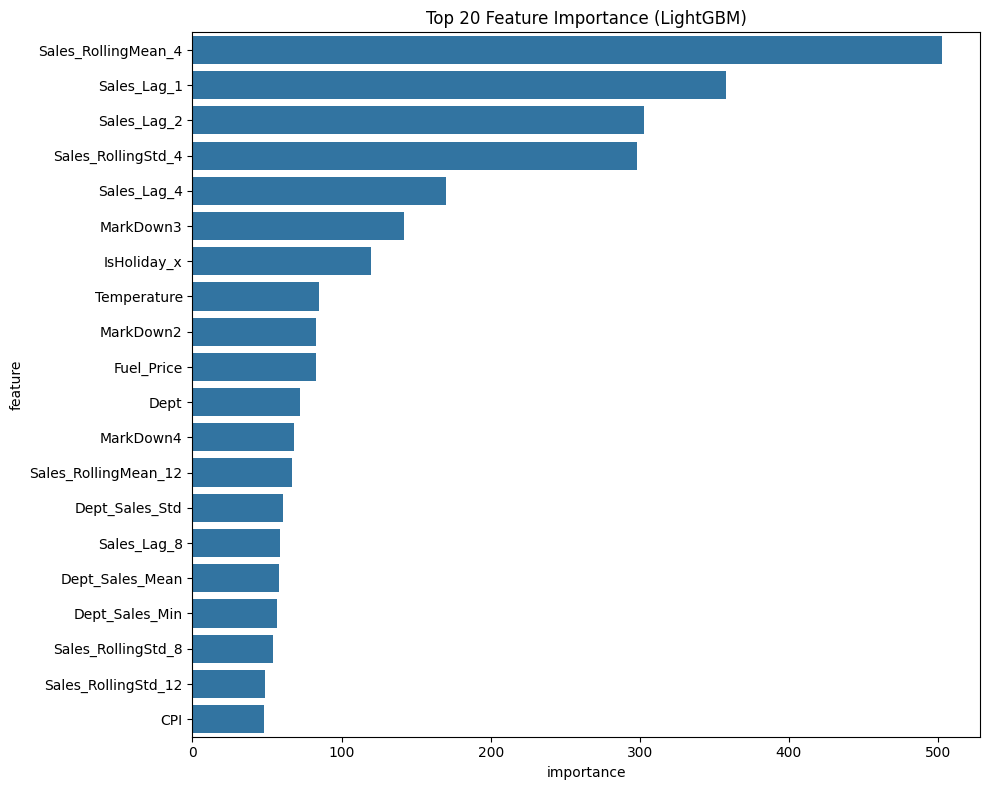

In [47]:

# =================================================================
# 4. Feature Selection and Engineering
# =================================================================

def run_feature_selection(train_data):
    """Run feature selection with MLflow tracking"""

    with mlflow.start_run(run_name="LightGBM_Feature_Selection"):

        # Prepare features
        feature_cols = [col for col in train_data.columns if col not in ['Weekly_Sales', 'Date']]

        # Handle missing values and prepare data
        X = train_data[feature_cols].copy()
        y = train_data['Weekly_Sales'].copy()

        # Apply preprocessing
        preprocessor = WalmartPreprocessor()
        X_processed = preprocessor.fit_transform(X)

        # Feature importance using LightGBM
        lgb_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            n_estimators=100,
            random_state=42,
            verbose=-1
        )

        lgb_model.fit(X_processed, y)

        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': lgb_model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Select top features
        top_features = feature_importance.head(20)['feature'].tolist()

        # Log parameters and metrics
        mlflow.log_param("total_features", len(feature_cols))
        mlflow.log_param("selected_features", len(top_features))
        mlflow.log_param("feature_selection_method", "lightgbm_importance")

        # Save feature importance plot
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
        plt.title('Top 20 Feature Importance (LightGBM)')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('feature_importance.png')
        plt.show()

        return top_features, preprocessor

# Run feature selection
selected_features, preprocessor = run_feature_selection(train_processed)


In [48]:

# =================================================================
# 5. Model Training with Cross-Validation
# =================================================================

def weighted_mean_absolute_error(y_true, y_pred, weights):
    """Calculate weighted MAE (Walmart competition metric)"""
    return np.average(np.abs(y_true - y_pred), weights=weights)

def run_lightgbm_training(train_data, selected_features):
    """Run LightGBM training with cross-validation"""

    with mlflow.start_run(run_name="LightGBM_CrossValidation"):

        # Check available columns to identify the holiday column
        print("Available columns:", train_data.columns.tolist())

        # Find the holiday column (could be IsHoliday, IsHoliday_x, or IsHoliday_y)
        holiday_col = None
        for col in train_data.columns:
            if 'IsHoliday' in col:
                holiday_col = col
                break

        if holiday_col is None:
            print("Warning: No holiday column found, using equal weights")
            weights = np.ones(len(train_data))
        else:
            print(f"Using holiday column: {holiday_col}")
            weights = np.where(train_data[holiday_col] == 1, 5, 1)

        # Prepare data
        X = train_data[selected_features].copy()
        y = train_data['Weekly_Sales'].copy()

        # Apply preprocessing
        X_processed = preprocessor.transform(X)

        # Convert to numpy array if it's not already
        if hasattr(X_processed, 'values'):
            X_processed = X_processed.values

        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)

        # LightGBM parameters
        lgb_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42
        }

        # Log parameters
        for param, value in lgb_params.items():
            mlflow.log_param(f"lgb_{param}", value)

        # Cross-validation results
        cv_scores = []
        cv_wmae_scores = []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_processed)):

            X_train_fold, X_val_fold = X_processed[train_idx], X_processed[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]  # Keep pandas for y
            weights_train = weights[train_idx]
            weights_val = weights[val_idx]

            # Train model
            lgb_model = lgb.LGBMRegressor(**lgb_params, n_estimators=1000)
            lgb_model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric='rmse',
                # early_stopping_rounds=50,
                # verbose=False
            )

            # Predictions
            y_pred = lgb_model.predict(X_val_fold)

            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            mae = mean_absolute_error(y_val_fold, y_pred)
            wmae = weighted_mean_absolute_error(y_val_fold, y_pred, weights_val)

            cv_scores.append(rmse)
            cv_wmae_scores.append(wmae)

            print(f"Fold {fold + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, WMAE = {wmae:.4f}")

        # Calculate mean CV scores
        mean_cv_rmse = np.mean(cv_scores)
        mean_cv_wmae = np.mean(cv_wmae_scores)
        std_cv_rmse = np.std(cv_scores)

        # Log metrics
        mlflow.log_metric("cv_rmse_mean", mean_cv_rmse)
        mlflow.log_metric("cv_rmse_std", std_cv_rmse)
        mlflow.log_metric("cv_wmae_mean", mean_cv_wmae)
        mlflow.log_metric("n_folds", len(cv_scores))

        print(f"\nCross-Validation Results:")
        print(f"Mean RMSE: {mean_cv_rmse:.4f} (+/- {std_cv_rmse:.4f})")
        print(f"Mean WMAE: {mean_cv_wmae:.4f}")

        return mean_cv_rmse, mean_cv_wmae

# Run cross-validation
cv_rmse, cv_wmae = run_lightgbm_training(train_processed, selected_features)


Available columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_12', 'Sales_RollingMean_4', 'Sales_RollingStd_4', 'Sales_RollingMean_8', 'Sales_RollingStd_8', 'Sales_RollingMean_12', 'Sales_RollingStd_12', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Min', 'Dept_Sales_Max', 'Dept_Sales_Median']
Using holiday column: IsHoliday_x
Fold 1: RMSE = 5257.0826, MAE = 1584.9029, WMAE = 1817.9057
Fold 2: RMSE = 2973.7617, MAE = 1255.9518, WMAE = 1392.4600
Fold 3: RMSE = 2887.9606, MAE = 1327.4586, WMAE = 1414.5709
Fold 4: RMSE = 2157.6880, MAE = 788.1549, WMAE = 872.9067
Fold 5: RMSE = 1787.9670, MAE = 847.2961, WMAE = 905.0099

Cross-Validation Results:
Mean RMSE: 3012.8920 (+/- 1207.0912)
Mean WMAE: 1280.5706


In [49]:

# =================================================================
# 6. Final Model Training and Pipeline Creation
# =================================================================

def create_final_pipeline(train_data, selected_features):
    """Create final LightGBM pipeline"""

    with mlflow.start_run(run_name="LightGBM_Final_Model"):

        # Prepare data
        X = train_data[selected_features].copy()
        y = train_data['Weekly_Sales'].copy()

        # Best parameters (you can tune these further)
        best_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42,
            'n_estimators': 1000
        }

        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', lgb.LGBMRegressor(**best_params))
        ])

        # Train pipeline
        pipeline.fit(X, y)

        # Log model parameters
        for param, value in best_params.items():
            mlflow.log_param(f"final_{param}", value)

        # Log final metrics
        y_pred = pipeline.predict(X)
        final_rmse = np.sqrt(mean_squared_error(y, y_pred))
        final_mae = mean_absolute_error(y, y_pred)

        mlflow.log_metric("final_train_rmse", final_rmse)
        mlflow.log_metric("final_train_mae", final_mae)

        # Log the model
        mlflow.sklearn.log_model(
            pipeline,
            "lightgbm_pipeline",
            registered_model_name="WalmartSales_LightGBM"
        )

        print(f"Final Model Training Complete!")
        print(f"Training RMSE: {final_rmse:.4f}")
        print(f"Training MAE: {final_mae:.4f}")

        return pipeline

# Create final pipeline
final_pipeline = create_final_pipeline(train_processed, selected_features)


2025/07/07 19:51:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 19:52:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Model Training Complete!
Training RMSE: 1880.4633
Training MAE: 986.9149


Registered model 'WalmartSales_LightGBM' already exists. Creating a new version of this model...
Created version '2' of model 'WalmartSales_LightGBM'.


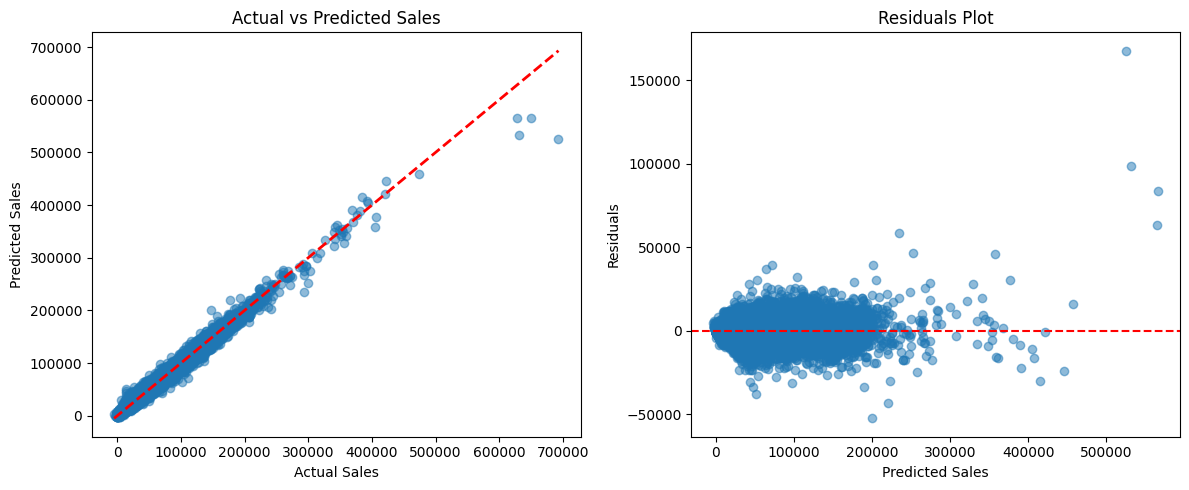

Model Evaluation Complete!
RMSE: 1880.4633
MAE: 986.9149
MAPE: inf%


In [50]:

# =================================================================
# 7. Model Evaluation and Validation
# =================================================================

def evaluate_model_performance(pipeline, train_data, selected_features):
    """Evaluate model performance with various metrics"""

    with mlflow.start_run(run_name="LightGBM_Model_Evaluation"):

        # Prepare data
        X = train_data[selected_features].copy()
        y = train_data['Weekly_Sales'].copy()

        # Make predictions
        y_pred = pipeline.predict(X)

        # Calculate comprehensive metrics
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / y)) * 100

        # Holiday vs non-holiday performance
        holiday_mask = train_data['IsHoliday_x'] == 1

        if holiday_mask.sum() > 0:
            holiday_rmse = np.sqrt(mean_squared_error(y[holiday_mask], y_pred[holiday_mask]))
            non_holiday_rmse = np.sqrt(mean_squared_error(y[~holiday_mask], y_pred[~holiday_mask]))

            mlflow.log_metric("holiday_rmse", holiday_rmse)
            mlflow.log_metric("non_holiday_rmse", non_holiday_rmse)

        # Log metrics
        mlflow.log_metric("evaluation_rmse", rmse)
        mlflow.log_metric("evaluation_mae", mae)
        mlflow.log_metric("evaluation_mape", mape)

        # Create residuals plot
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(y, y_pred, alpha=0.5)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        plt.xlabel('Actual Sales')
        plt.ylabel('Predicted Sales')
        plt.title('Actual vs Predicted Sales')

        plt.subplot(1, 2, 2)
        residuals = y - y_pred
        plt.scatter(y_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Sales')
        plt.ylabel('Residuals')
        plt.title('Residuals Plot')

        plt.tight_layout()
        plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
        mlflow.log_artifact('model_evaluation.png')
        plt.show()

        print(f"Model Evaluation Complete!")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")

        return rmse, mae, mape

# Evaluate model
eval_rmse, eval_mae, eval_mape = evaluate_model_performance(final_pipeline, train_processed, selected_features)


In [51]:
# =================================================================
# 8. Hyperparameter Tuning (Optional)
# =================================================================

def run_hyperparameter_tuning(train_data, selected_features, n_trials=20):
    """Run hyperparameter tuning for LightGBM"""

    with mlflow.start_run(run_name="LightGBM_Hyperparameter_Tuning"):

        # Find the holiday column for weights
        holiday_col = None
        for col in train_data.columns:
            if 'IsHoliday' in col:
                holiday_col = col
                break

        if holiday_col is None:
            weights = np.ones(len(train_data))
        else:
            weights = np.where(train_data[holiday_col] == 1, 5, 1)

        # Prepare data
        X = train_data[selected_features].copy()
        y = train_data['Weekly_Sales'].copy()
        X_processed = preprocessor.transform(X)

        # Convert to numpy array if it's not already
        if hasattr(X_processed, 'values'):
            X_processed = X_processed.values

        # Define parameter grid
        param_grid = {
            'num_leaves': [20, 31, 40],
            'learning_rate': [0.01, 0.05, 0.1],
            'feature_fraction': [0.8, 0.9, 1.0],
            'bagging_fraction': [0.7, 0.8, 0.9],
            'min_child_samples': [20, 30, 40]
        }

        best_score = float('inf')
        best_params = None

        # Simple grid search (you can use optuna for more advanced tuning)
        from itertools import product

        param_combinations = list(product(
            param_grid['num_leaves'],
            param_grid['learning_rate'],
            param_grid['feature_fraction'],
            param_grid['bagging_fraction'],
            param_grid['min_child_samples']
        ))

        # Sample a subset for demonstration
        np.random.seed(42)
        sampled_combinations = np.random.choice(
            len(param_combinations),
            size=min(n_trials, len(param_combinations)),
            replace=False
        )

        for i, idx in enumerate(sampled_combinations):
            num_leaves, lr, feat_frac, bag_frac, min_child = param_combinations[idx]

            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'num_leaves': num_leaves,
                'learning_rate': lr,
                'feature_fraction': feat_frac,
                'bagging_fraction': bag_frac,
                'bagging_freq': 5,
                'min_child_samples': min_child,
                'verbose': -1,
                'random_state': 42,
                'n_estimators': 500
            }

            # Cross-validation
            tscv = TimeSeriesSplit(n_splits=3)
            cv_scores = []
            cv_wmae_scores = []

            for train_idx, val_idx in tscv.split(X_processed):
                X_train_fold, X_val_fold = X_processed[train_idx], X_processed[val_idx]
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
                weights_val = weights[val_idx]

                # Create LightGBM model
                lgb_model = lgb.LGBMRegressor(**params)

                # Fit with updated syntax
                lgb_model.fit(
                    X_train_fold, y_train_fold,
                    eval_set=[(X_val_fold, y_val_fold)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
                )

                # Predictions
                y_pred = lgb_model.predict(X_val_fold)

                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
                wmae = weighted_mean_absolute_error(y_val_fold, y_pred, weights_val)

                cv_scores.append(rmse)
                cv_wmae_scores.append(wmae)

            mean_cv_score = np.mean(cv_scores)
            mean_cv_wmae = np.mean(cv_wmae_scores)

            if mean_cv_score < best_score:
                best_score = mean_cv_score
                best_params = params.copy()
                best_params['best_cv_wmae'] = mean_cv_wmae

            print(f"Trial {i+1}/{len(sampled_combinations)}: CV RMSE = {mean_cv_score:.4f}, CV WMAE = {mean_cv_wmae:.4f}")

        # Log best parameters
        mlflow.log_param("tuning_trials", len(sampled_combinations))
        mlflow.log_metric("best_cv_rmse", best_score)
        mlflow.log_metric("best_cv_wmae", best_params.get('best_cv_wmae', 0))

        # Remove the metric from params before logging
        best_params_clean = {k: v for k, v in best_params.items() if k != 'best_cv_wmae'}

        for param, value in best_params_clean.items():
            mlflow.log_param(f"best_{param}", value)

        print(f"\nBest Parameters Found:")
        for param, value in best_params_clean.items():
            print(f"{param}: {value}")
        print(f"Best CV RMSE: {best_score:.4f}")
        print(f"Best CV WMAE: {best_params.get('best_cv_wmae', 'N/A'):.4f}")

        return best_params_clean

# Run hyperparameter tuning (optional - can be time-consuming)
best_params = run_hyperparameter_tuning(train_processed, selected_features, n_trials=10)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 4807.18
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 3521.76
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 2908.97
Trial 1/10: CV RMSE = 3745.9392, CV WMAE = 1754.0082
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 4871.28
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 3637.28
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 3040.43
Trial 2/10: CV RMSE = 3849.5994, CV WMAE = 1801.5317
Training until validation scores don't improve for 50 rounds

In [ ]:

# =================================================================
# 9. Final Model Registration
# =================================================================

def register_best_model(pipeline):
    """Register the best model in MLflow Model Registry"""

    with mlflow.start_run(run_name="LightGBM_Model_Registration"):

        # Log final model info
        mlflow.log_param("model_type", "LightGBM_Pipeline")
        mlflow.log_param("framework", "scikit-learn + LightGBM")
        mlflow.log_param("purpose", "Walmart Sales Forecasting")

        # Register model
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/lightgbm_pipeline"

        # Register in Model Registry
        mlflow.register_model(
            model_uri=model_uri,
            name="WalmartSales_LightGBM_Final",
            # description="Final LightGBM model for Walmart Sales Forecasting competition"
        )

        print("Model successfully registered in MLflow Model Registry!")
        print("Model name: WalmartSales_LightGBM_Final")

# Register the model
register_best_model(final_pipeline)


In [53]:
def register_best_model(model, model_name="WalmartSales_LightGBM_Final"):
    """Register the best model in MLflow Model Registry"""

    with mlflow.start_run(run_name="LightGBM_Model_Registration"):

        # Log the model first
        mlflow.lightgbm.log_model(
            lgb_model=model,
            artifact_path="lightgbm_pipeline",
            registered_model_name=model_name,
            signature=None,  # You can add signature if needed
            input_example=None  # You can add input example if needed
        )

        # Get the current run ID
        run_id = mlflow.active_run().info.run_id
        model_uri = f"runs:/{run_id}/lightgbm_pipeline"

        print(f"Model registered successfully!")
        print(f"Model URI: {model_uri}")
        print(f"Model Name: {model_name}")

        return model_uri

# Register the model
model_uri = register_best_model(final_pipeline)

2025/07/07 20:06:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/07 20:06:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model registered successfully!
Model URI: runs:/df921bad20d544ec933f2a65ac1dc4b5/lightgbm_pipeline
Model Name: WalmartSales_LightGBM_Final


Registered model 'WalmartSales_LightGBM_Final' already exists. Creating a new version of this model...
Created version '2' of model 'WalmartSales_LightGBM_Final'.


In [54]:

# =================================================================
# 10. Summary and Next Steps
# =================================================================

print("\n" + "="*60)
print("LIGHTGBM MODEL EXPERIMENT COMPLETE")
print("="*60)
print(f"✓ Data preprocessing completed")
print(f"✓ Feature engineering and selection completed")
print(f"✓ Cross-validation RMSE: {cv_rmse:.4f}")
print(f"✓ Final model evaluation RMSE: {eval_rmse:.4f}")
print(f"✓ Final model evaluation MAE: {eval_mae:.4f}")
print(f"✓ Final model evaluation MAPE: {eval_mape:.2f}%")
print(f"✓ Model registered in MLflow Model Registry")
print("\nNext steps:")
print("1. Run model_inference.ipynb to make predictions on test set")
print("2. Compare with other model architectures")
print("3. Submit predictions to Kaggle competition")
print("="*60)

# Save the final pipeline for inference
import joblib
joblib.dump(final_pipeline, 'lightgbm_final_pipeline.pkl')
print("Pipeline saved as 'lightgbm_final_pipeline.pkl'")

# Create a summary report
summary_report = {
    'Model': 'LightGBM',
    'CV_RMSE': cv_rmse,
    'CV_WMAE': cv_wmae,
    'Final_RMSE': eval_rmse,
    'Final_MAE': eval_mae,
    'Final_MAPE': eval_mape,
    'Selected_Features': len(selected_features),
    'Model_Registered': True
}

import json
with open('lightgbm_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("Summary report saved as 'lightgbm_summary.json'")


LIGHTGBM MODEL EXPERIMENT COMPLETE
✓ Data preprocessing completed
✓ Feature engineering and selection completed
✓ Cross-validation RMSE: 3012.8920
✓ Final model evaluation RMSE: 1880.4633
✓ Final model evaluation MAE: 986.9149
✓ Final model evaluation MAPE: inf%
✓ Model registered in MLflow Model Registry

Next steps:
1. Run model_inference.ipynb to make predictions on test set
2. Compare with other model architectures
3. Submit predictions to Kaggle competition
Pipeline saved as 'lightgbm_final_pipeline.pkl'
Summary report saved as 'lightgbm_summary.json'
